In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Load dataset
df = pd.read_csv('merged_AAPL_data.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Feature selection & Scaling
stock_economic_features = ['open', 'high', 'low', 'close', 'volume', 'SMA', 'EMA', 'GDP', 'CPI_inflation_rate']
sentiment_features = ['positive', 'neutral', 'negative']

scaler_stock = MinMaxScaler()
scaler_stock.fit(df[stock_economic_features])

scaler_sentiment = MinMaxScaler()
scaler_sentiment.fit(df[sentiment_features])

# Save the updated scalers
joblib.dump(scaler_stock, "scaler_stock.pkl")
joblib.dump(scaler_sentiment, "scaler_sentiment.pkl")

# Transform the data
stock_economic_scaled = scaler_stock.transform(df[stock_economic_features])
sentiment_scaled = scaler_sentiment.transform(df[sentiment_features])

# Function to create sequences
def create_sequences(data, seq_length=10):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

seq_length = 10  # Adjusting for better temporal pattern capture
X_stock_economic = create_sequences(stock_economic_scaled, seq_length)
X_sentiment = create_sequences(sentiment_scaled, seq_length)
y = stock_economic_scaled[seq_length:, 3]  # Predicting 'close' price

# Split data into training and testing sets
X_train_stock_economic, X_test_stock_economic, X_train_sentiment, X_test_sentiment, y_train, y_test = train_test_split(
    X_stock_economic, X_sentiment, y, test_size=0.2, random_state=42
)

# Transformer Block for Attention Mechanism
def transformer_block(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    """ Transformer Encoder Block with Multi-Head Attention."""
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual Connection
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)    
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)    
    transformer_output = Add()([attention_output, ff_output])  # Residual Connection
    transformer_output = LayerNormalization(epsilon=1e-6)(transformer_output)    
    return transformer_output

# Build Transformer-LSTM Model
def build_model(lstm_units, dropout_rate, num_heads=4, ff_dim=64):
    """ Builds the Transformer-LSTM Hybrid Model"""
    stock_input = Input(shape=(seq_length, X_train_stock_economic.shape[2]))
    sentiment_input = Input(shape=(seq_length, X_train_sentiment.shape[2]))

    # Transformer Block
    stock_transformed = transformer_block(stock_input, num_heads, ff_dim, dropout_rate)
    sentiment_transformed = transformer_block(sentiment_input, num_heads, ff_dim, dropout_rate)
    
    # LSTM Layers for Sequential Learning
    x_stock = LSTM(int(lstm_units), return_sequences=False)(stock_transformed)
    x_stock = Dropout(dropout_rate)(x_stock)
    
    x_sentiment = LSTM(int(lstm_units), return_sequences=False)(sentiment_transformed)
    x_sentiment = Dropout(dropout_rate)(x_sentiment)

    # Concatenation of Features
    merged = Add()([x_stock, x_sentiment])
    
    # Fully Connected Layer
    output = Dense(1)(merged)
    model = Model(inputs=[stock_input, sentiment_input], outputs=output)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))    
    return model

# Function for Bayesian Optimization
def train_evaluate(lstm_units, dropout_rate):
    """Trains and evaluates the model for Bayesian Optimization"""
    model = build_model(int(lstm_units), dropout_rate)
    
    model.fit(
        [X_train_stock_economic, X_train_sentiment], y_train,
        validation_data=([X_test_stock_economic, X_test_sentiment], y_test),
        epochs=15, batch_size=32, verbose=0
    )
    
    loss = model.evaluate([X_test_stock_economic, X_test_sentiment], y_test, verbose=0)
    return -loss  # Bayesian optimization maximizes, so return negative loss

# Bayesian Optimization
pbounds = {'lstm_units': (32, 128), 'dropout_rate': (0.3, 0.5)}

optimizer = BayesianOptimization(
    f=train_evaluate,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=7, n_iter=12)

# Best parameters
best_params = optimizer.max['params']
print(f"Best Parameters: {best_params}")

# Train final model with best parameters
final_model = build_model(best_params['lstm_units'], best_params['dropout_rate'])
final_model.fit(
    [X_train_stock_economic, X_train_sentiment], y_train,
    validation_data=([X_test_stock_economic, X_test_sentiment], y_test),
    epochs=60, batch_size=32, verbose=1
)

# Save the full model
final_model.save("Attention_Transformer_LSTM_Model.h5")

# Make Predictions
test_predictions = final_model.predict([X_test_stock_economic, X_test_sentiment])

# Evaluation Metrics
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, test_predictions)

print(f"\nOptimized Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------
| 1         | -0.001399 | 0.3749    | 123.3     |
| 2         | -0.002613 | 0.4464    | 89.47     |
| 3         | -0.001854 | 0.3312    | 46.98     |
| 4         | -0.002256 | 0.3116    | 115.2     |
| 5         | -0.002304 | 0.4202    | 99.97     |
| 6         | -0.002307 | 0.3041    | 125.1     |
| 7         | -0.001803 | 0.4665    | 52.38     |
| 8         | -0.001897 | 0.3558    | 123.2     |
| 9         | -0.002165 | 0.4009    | 123.3     |
| 10        | -0.001924 | 0.3203    | 82.08     |
| 11        | -0.001866 | 0.3011    | 76.52     |
| 12        | -0.002796 | 0.4335    | 93.65     |
| 13        | -0.001698 | 0.3065    | 52.66     |
| 14        | -0.002217 | 0.3884    | 111.1     |
| 15        | -0.002104 | 0.3037    | 74.08     |
| 16        | -0.003387 | 0.379     | 78.79     |
| 17        | -0.005141 | 0.438     | 43.75     |
| 18        | -0.001924 | 0.4208    | 46.56     |


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step

Optimized Evaluation Metrics:
MSE: 0.0015
MAE: 0.0309
RMSE: 0.0388
R² Score: 0.9672


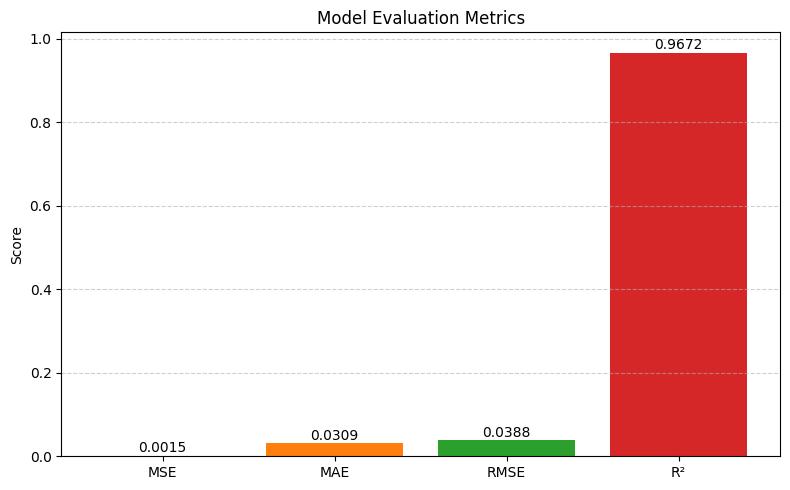

In [2]:
import matplotlib.pyplot as plt

# Define metrics
metrics = ['MSE', 'MAE', 'RMSE', 'R²']
values = [mse, mae, rmse, r2]

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.001, f'{yval:.4f}', ha='center', va='bottom')

# Title and axis labels
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [3]:
import matplotlib.pyplot as plt

metrics = ['MAE', 'MSE', 'RMSE', 'R²']
existing_values = [0.0421, 0.0025, 0.0501, 0.9165]
proposed_values = [0.0309, 0.0015, 0.0388, 0.9672]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(5, 4))
    plt.bar(['TLSTM', 'AT-LSTM'], [existing_values[i], proposed_values[i]], color=['skyblue', 'lightgreen'])
    plt.ylabel('Value')
    plt.ylim(0, max(existing_values[i], proposed_values[i]) * 1.2)
    for j, val in enumerate([existing_values[i], proposed_values[i]]):
        plt.text(j, val + 0.01 * val, f'{val:.4f}', ha='center')
    
    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.png')  # Saves each chart as a PNG file
    plt.close()